# WeGo Public Transit

#### Questions

1. How much impact does being late or too spaced out at the first stop have downstream?


2. What is the impact of the layover at the start of the trip (the difference between the first top arrival and departure time)? Does more layover lead to more stable headways (lower values for % headway deviation)?

#### Read in Data

In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
wego = pd.read_csv('../data/Headway Data, 8-1-2023 to 9-30-2023.csv', na_values= "NULL")
wego.head(1)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.5


#### Drop Null and NaN values

In [3]:
wego['ACTUAL_ARRIVAL_TIME'].isna().sum()

11459

In [4]:
wego_drop = wego[wego['ACTUAL_ARRIVAL_TIME'] != 'NULL']
wego_drop = wego.dropna(subset=['ACTUAL_ARRIVAL_TIME'])

In [5]:
wego_drop.head(1)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.5


#### Identify arrival times in 24th in 25th hour

- Arrival times are on a 24 hour clock. In rows where the hour is 24 and 25 the date is not adjusted to the next day. Initially, I made a function that adjusts the date forward and corrects the time to 0000 and 01000. 


- Doing this pushes the last portion of an operators shift to the following day. If the last stop of a shift occurs at 0100 it will be listed as the first stop of a shift the following day if it is not removed from the data. 


- I created an 'Hours' column to drop all rows where the hour is 24 or 25. 

In [6]:
wego_drop['Hours'] = wego_drop['ACTUAL_ARRIVAL_TIME'].str[:2]
wego_drop['Hours'] = wego_drop['Hours'].str.replace(':', '', regex=True)
wego_drop['Hours'] = wego_drop['Hours'].astype(int)

<ipython-input-6-52d78353f073>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['Hours'] = wego_drop['ACTUAL_ARRIVAL_TIME'].str[:2]
<ipython-input-6-52d78353f073>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['Hours'] = wego_drop['Hours'].str.replace(':', '', regex=True)
<ipython-input-6-52d78353f073>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [7]:
after_midnight = wego_drop['Hours'].value_counts().reset_index().rename(columns ={'index':'Hours','Hours':'Count'})
after_midnight.head(25) # Check count of rows with 24 and 25
twentyfour = after_midnight['Count'].iloc[19]
twentyfive = after_midnight['Count'].iloc[21]

#### Drop rows where time is in 24 and 25th hour

In [8]:
values_to_drop = [24, 25]
wego_drop = wego_drop[~wego_drop['Hours'].isin(values_to_drop)]

In [9]:
after_midnight_drop = wego_drop['Hours'].value_counts().reset_index().rename(columns ={'index':'Hours','Hours':'Count'})

In [10]:
before = after_midnight['Count'].sum()
after = after_midnight_drop['Count'].sum()

In [11]:
after - before

-4428

In [12]:
twentyfour + twentyfive

4428

#### Convert Arrival Time to Datetime object

- To compare first stop lateness' effect on last stop lateness, I need to rank the arrival times in an operator's shift that resets after each shift. 


- After the rank is created I can identify the adherence at the first and last stops. 

In [13]:
wego_drop.dtypes

CALENDAR_ID                    int64
SERVICE_ABBR                   int64
ADHERENCE_ID                   int64
DATE                          object
ROUTE_ABBR                     int64
BLOCK_ABBR                     int64
OPERATOR                       int64
TRIP_ID                        int64
OVERLOAD_ID                    int64
ROUTE_DIRECTION_NAME          object
TIME_POINT_ABBR               object
ROUTE_STOP_SEQUENCE          float64
TRIP_EDGE                      int64
LATITUDE                     float64
LONGITUDE                    float64
SCHEDULED_TIME                object
ACTUAL_ARRIVAL_TIME           object
ACTUAL_DEPARTURE_TIME         object
ADHERENCE                    float64
SCHEDULED_HDWY               float64
ACTUAL_HDWY                  float64
HDWY_DEV                     float64
ADJUSTED_EARLY_COUNT           int64
ADJUSTED_LATE_COUNT            int64
ADJUSTED_ONTIME_COUNT          int64
STOP_CANCELLED                 int64
PREV_SCHED_STOP_CANCELLED    float64
I

Convert arrival time to datetime

In [14]:
wego_drop['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego_drop['ACTUAL_ARRIVAL_TIME']).dt.time

Create a rank that is grouped by the operate and date (the rank resets when operator/day changes)

In [15]:
wego_drop['Arrival Time (seconds)'] = wego_drop.groupby(['OPERATOR', 'DATE'])['ACTUAL_ARRIVAL_TIME'].transform(lambda x: x.apply(lambda y: y.hour * 3600 + y.minute * 60 + y.second))
wego_drop['Rank'] = wego_drop.groupby(['OPERATOR', 'DATE'])['Arrival Time (seconds)'].rank(method='first')

created a new dataframe to check if rank function worked properly

In [16]:
eda = wego_drop[['DATE','OPERATOR','ACTUAL_ARRIVAL_TIME','Rank','ADHERENCE']]
eda.head()

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,Rank,ADHERENCE
0,8/1/2023,1040,04:37:38,1.0,-2.133333
1,8/1/2023,1040,04:48:27,2.0,-2.450000
2,8/1/2023,1040,04:54:56,3.0,-0.933333
3,8/1/2023,1040,05:03:43,4.0,6.283333
4,8/1/2023,1040,05:03:43,5.0,-1.583333


Create a function that identifies all first stop adherence values

In [18]:
def find_min_adherence(eda):
    result = pd.DataFrame(columns=eda.columns)  # Initialize an empty DataFrame
    for day, driver_df in eda.groupby(['DATE', 'OPERATOR']):
        min_rank_index = driver_df['Rank'].idxmin()
        min_adherence_row = eda.loc[min_rank_index]
        result = pd.concat([result, min_adherence_row.to_frame().T], ignore_index=True)
    return result

min_adherence = find_min_adherence(eda)
min_adherence.head()

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,Rank,ADHERENCE
0,8/1/2023,304,16:21:10,1,-0.1
1,8/1/2023,326,14:53:53,1,-8.88333
2,8/1/2023,332,06:11:05,1,8.85
3,8/1/2023,341,04:56:23,1,5.73333
4,8/1/2023,357,10:19:47,1,-6.31667


Create a function that identifies all first stop adherence values

In [21]:
def find_max_adherence(eda):
    result = pd.DataFrame(columns=eda.columns)
    for day, driver_df in eda.groupby(['DATE', 'OPERATOR']):
        max_rank_index = driver_df['Rank'].idxmax()
        max_adherence_row = eda.loc[max_rank_index]
        result = pd.concat([result, max_adherence_row.to_frame().T], ignore_index=True)
    return result

max_adherence = find_max_adherence(eda)
max_adherence.head()

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,Rank,ADHERENCE
0,8/1/2023,304,23:54:10,59,-0.166666
1,8/1/2023,326,23:59:21,62,-3.35
2,8/1/2023,332,15:35:17,59,-5.28333
3,8/1/2023,341,13:06:33,31,-0.55
4,8/1/2023,357,19:06:53,66,-6.86667


In [22]:
#eda.to_csv('eda.csv', index=False)
#max_adherence.to_csv('max_arrival_times.csv', index=False)
#min_adherence.to_csv('min_arrival_times.csv', index=False)

Create dataframe with min and max adherence as two columns

In [23]:
min_max_adherence = pd.merge(max_adherence, min_adherence, on=['DATE','OPERATOR'], how='inner')

Dropped columns

In [24]:
min_max_adherence.drop(columns=['ACTUAL_ARRIVAL_TIME_x','ACTUAL_ARRIVAL_TIME_y'], axis = 1, inplace=True)
min_max_adherence.head(1)

,DATE,OPERATOR,Rank_x,ADHERENCE_x,Rank_y,ADHERENCE_y
0,8/1/2023,304,59,-0.166666,1,-0.1


Renamed columns

In [25]:
min_max_adherence = min_max_adherence.rename(columns={'Rank_x': 'MAX_RANK', 'ADHERENCE_x': 'MAX_ADHERENCE','Rank_y': 'MIN_RANK','ADHERENCE_y': 'MIN_ADHERENCE'})
min_max_adherence.head(1)

,DATE,OPERATOR,MAX_RANK,MAX_ADHERENCE,MIN_RANK,MIN_ADHERENCE
0,8/1/2023,304,59,-0.166666,1,-0.1


Convert adherence columns to floats

In [26]:
min_max_adherence['MAX_ADHERENCE'] = min_max_adherence['MAX_ADHERENCE'].astype(float)
min_max_adherence['MIN_ADHERENCE'] = min_max_adherence['MIN_ADHERENCE'].astype(float)

In [27]:
min_max_adherence.dtypes

DATE              object
OPERATOR          object
MAX_RANK          object
MAX_ADHERENCE    float64
MIN_RANK          object
MIN_ADHERENCE    float64
dtype: object

In [28]:
min_max_adherence[['DATE', 'OPERATOR','MIN_ADHERENCE','MAX_ADHERENCE']]

,DATE,OPERATOR,MIN_ADHERENCE,MAX_ADHERENCE
0,8/1/2023,304,-0.100000,-0.166666
1,8/1/2023,326,-8.883333,-3.350000
2,8/1/2023,332,8.850000,-5.283333
3,8/1/2023,341,5.733333,-0.550000
4,8/1/2023,357,-6.316666,-6.866666
...,...,...,...,...
7861,9/9/2023,3101,-10.633333,-55.700000
7862,9/9/2023,3116,3.250000,-7.266666
7863,9/9/2023,3122,-2.650000,-7.000000
7864,9/9/2023,3129,-0.116666,-2.616666


In [29]:
min_max_adherence[['MIN_ADHERENCE', 'MAX_ADHERENCE']].corr()

,MIN_ADHERENCE,MAX_ADHERENCE
MIN_ADHERENCE,1.000000,0.045887
MAX_ADHERENCE,0.045887,1.000000


## Unused Functions

This function adjusts the date forward if the Arrival Time is in 24th or 25th hour

In [30]:
# Define the adjust_date function
#def adjust_date(row):
    #time_obj = str(row['ACTUAL_ARRIVAL_TIME'])
    #if time_obj.startswith('24') or time_obj.startswith('25'):
        #row['DATE'] = (datetime.strptime(row['DATE'], '%m/%d/%Y') + timedelta(days=1)).strftime('%m/%d/%Y')
    #return row

# Apply the function to the DataFrame
#wego = wego.apply(adjust_date, axis=1)

Lines below finds and replaces 24 and 45 hours to 0000 and 0100

In [31]:
#wego['ACTUAL_ARRIVAL_TIME'] = wego['ACTUAL_ARRIVAL_TIME'].str.replace('24', '00')
#wego['ACTUAL_ARRIVAL_TIME'] = wego['ACTUAL_ARRIVAL_TIME'].str.replace('25', '01')
#wego['ACTUAL_DEPARTURE_TIME'] = wego['ACTUAL_DEPARTURE_TIME'].str.replace('24', '00')
#wego['ACTUAL_DEPARTURE_TIME'] = wego['ACTUAL_DEPARTURE_TIME'].str.replace('25', '01')
#wego['SCHEDULED_TIME'] = wego['SCHEDULED_TIME'].str.replace('24', '00')
#wego['SCHEDULED_TIME'] = wego['SCHEDULED_TIME'].str.replace('25', '01')

Converts times to datetime

In [32]:
#wego['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego['ACTUAL_ARRIVAL_TIME']).dt.time
#wego['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(wego['ACTUAL_DEPARTURE_TIME']).dt.time
#wego['SCHEDULED_TIME'] = pd.to_datetime(wego['SCHEDULED_TIME']).dt.time

## Trip Edge EDA

In [33]:
wego_drop.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,Hours,Arrival Time (seconds),Rank
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,2,6.500000,4,16658,1.0
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,9,0.000000,4,17307,2.0
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,19,0.000000,4,17696,3.0
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,NaN,0,35,0.000000,5,18223,4.0
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,1,0,0.0,0,36,12.866666,5,18223,5.0


In [34]:
wego_drop['DATE_STR'] = wego_drop['DATE'].astype(str)
wego_drop['TRIP_ID_STR'] = wego_drop['TRIP_ID'].astype(str)
wego_drop.dtypes

CALENDAR_ID                    int64
SERVICE_ABBR                   int64
ADHERENCE_ID                   int64
DATE                          object
ROUTE_ABBR                     int64
BLOCK_ABBR                     int64
OPERATOR                       int64
TRIP_ID                        int64
OVERLOAD_ID                    int64
ROUTE_DIRECTION_NAME          object
TIME_POINT_ABBR               object
ROUTE_STOP_SEQUENCE          float64
TRIP_EDGE                      int64
LATITUDE                     float64
LONGITUDE                    float64
SCHEDULED_TIME                object
ACTUAL_ARRIVAL_TIME           object
ACTUAL_DEPARTURE_TIME         object
ADHERENCE                    float64
SCHEDULED_HDWY               float64
ACTUAL_HDWY                  float64
HDWY_DEV                     float64
ADJUSTED_EARLY_COUNT           int64
ADJUSTED_LATE_COUNT            int64
ADJUSTED_ONTIME_COUNT          int64
STOP_CANCELLED                 int64
PREV_SCHED_STOP_CANCELLED    float64
I

In [35]:
wego_drop['CORRECTED_TRIP_ID'] = wego_drop['DATE_STR'] + "-" + wego_drop['TRIP_ID_STR']

In [36]:
wego_drop[['CORRECTED_TRIP_ID']]

,CORRECTED_TRIP_ID
0,8/1/2023-345104
1,8/1/2023-345104
2,8/1/2023-345104
3,8/1/2023-345104
4,8/1/2023-345105
...,...
350323,9/30/2023-353448
350324,9/30/2023-353448
350325,9/30/2023-353449
350326,9/30/2023-353449


In [37]:
wego_drop['TRIP_RANK'] = wego_drop.groupby(['OPERATOR', 'CORRECTED_TRIP_ID'])['Arrival Time (seconds)'].rank(method='first')

In [38]:
trip_edge_eda = wego_drop[['DATE','OPERATOR','ACTUAL_ARRIVAL_TIME','CORRECTED_TRIP_ID','TRIP_EDGE','TRIP_RANK','ADHERENCE','DWELL_IN_MINS']]
trip_edge_eda.head()

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,CORRECTED_TRIP_ID,TRIP_EDGE,TRIP_RANK,ADHERENCE,DWELL_IN_MINS
0,8/1/2023,1040,04:37:38,8/1/2023-345104,1,1.0,-2.133333,6.500000
1,8/1/2023,1040,04:48:27,8/1/2023-345104,0,2.0,-2.450000,0.000000
2,8/1/2023,1040,04:54:56,8/1/2023-345104,0,3.0,-0.933333,0.000000
3,8/1/2023,1040,05:03:43,8/1/2023-345104,2,4.0,6.283333,0.000000
4,8/1/2023,1040,05:03:43,8/1/2023-345105,1,1.0,-1.583333,12.866666


In [39]:
filtered_date = '8/1/2023'
trip_edge_eda_304 = trip_edge_eda[(trip_edge_eda['OPERATOR'] == 304) & (trip_edge_eda['DATE'] == filtered_date)]
trip_edge_eda_304.head(5)

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,CORRECTED_TRIP_ID,TRIP_EDGE,TRIP_RANK,ADHERENCE,DWELL_IN_MINS
2714,8/1/2023,304,16:21:10,8/1/2023-347045,1,1.0,-0.100000,8.933333
2715,8/1/2023,304,16:45:19,8/1/2023-347045,0,2.0,-3.316666,0.000000
2716,8/1/2023,304,16:51:29,8/1/2023-347045,0,3.0,-6.616666,2.133333
2717,8/1/2023,304,16:59:33,8/1/2023-347045,0,4.0,-11.183333,3.633333
2718,8/1/2023,304,17:14:39,8/1/2023-347045,0,5.0,-16.733333,3.083333


In [40]:
#trip_edge_eda_304.to_csv('eda.csv', index=False)

Find min rank adherence

In [50]:
def find_min_rank_adherence(trip_edge_eda):
    # Group by 'Trip ID' and find the row with the minimum 'Rank'
    min_rank_adherence_df = trip_edge_eda.loc[trip_edge_eda.groupby('CORRECTED_TRIP_ID')['TRIP_RANK'].idxmin()]
    
    return min_rank_adherence_df

min_rank_adherence = find_min_rank_adherence(trip_edge_eda)

In [52]:
min_rank_adherence.head(5)

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,CORRECTED_TRIP_ID,TRIP_EDGE,TRIP_RANK,ADHERENCE,DWELL_IN_MINS
0,8/1/2023,1040,04:37:38,8/1/2023-345104,1,1.0,-2.133333,6.500000
4,8/1/2023,1040,05:03:43,8/1/2023-345105,1,1.0,-1.583333,12.866666
7,8/1/2023,1040,05:30:30,8/1/2023-345106,1,1.0,-1.716666,13.216666
11,8/1/2023,1040,06:05:31,8/1/2023-345107,1,1.0,-1.316666,10.800000
14,8/1/2023,1040,06:30:59,8/1/2023-345108,1,1.0,-1.516666,12.533333


Find max rank adherence

In [53]:
def find_max_rank_adherence(trip_edge_eda):
    # Group by 'Trip ID' and find the row with the minimum 'Rank'
    max_rank_adherence_df = trip_edge_eda.loc[trip_edge_eda.groupby('CORRECTED_TRIP_ID')['TRIP_RANK'].idxmax()]
    
    return max_rank_adherence_df

max_rank_adherence = find_max_rank_adherence(trip_edge_eda)

In [54]:
max_rank_adherence.head(5)

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,CORRECTED_TRIP_ID,TRIP_EDGE,TRIP_RANK,ADHERENCE,DWELL_IN_MINS
3,8/1/2023,1040,05:03:43,8/1/2023-345104,2,4.0,6.283333,0.0
6,8/1/2023,1040,05:30:30,8/1/2023-345105,2,3.0,1.500000,0.0
10,8/1/2023,1040,06:05:31,8/1/2023-345106,2,4.0,4.483333,0.0
13,8/1/2023,1040,06:30:59,8/1/2023-345107,2,3.0,4.016666,0.0
17,8/1/2023,1040,07:05:49,8/1/2023-345108,2,4.0,4.183333,0.0


In [55]:
#max_rank_adherence.to_csv('max_rank_adherence.csv', index=False)
#min_rank_adherence.to_csv('min_rank_adherence.csv', index=False)

In [86]:
#filtered_date = '8/1/2023'
#trip_edge_eda_304 = trip_edge_eda[(trip_edge_eda['OPERATOR'] == 304) & (trip_edge_eda['DATE'] == filtered_date) & (trip_edge_eda['TRIP_EDGE'] == 1)]
#trip_edge_eda_304.head(20)

In [87]:
#filtered_date = '8/1/2023'
#trip_edge = [0, 2]
#trip_edge_eda_326 = trip_edge_eda[(trip_edge_eda['OPERATOR'] == 326) & (trip_edge_eda['DATE'] == filtered_date) & (trip_edge_eda['TRIP_EDGE'].isin(trip_edge))]
#trip_edge_eda_326.head()

In [108]:
min_max_rank_adherence = pd.merge(max_rank_adherence, min_rank_adherence, on=['CORRECTED_TRIP_ID'], how='inner')

In [109]:
min_max_rank_adherence.head()

,DATE_x,OPERATOR_x,ACTUAL_ARRIVAL_TIME_x,CORRECTED_TRIP_ID,TRIP_EDGE_x,TRIP_RANK_x,ADHERENCE_x,DWELL_IN_MINS_x,DATE_y,OPERATOR_y,ACTUAL_ARRIVAL_TIME_y,TRIP_EDGE_y,TRIP_RANK_y,ADHERENCE_y,DWELL_IN_MINS_y
0,8/1/2023,1040,05:03:43,8/1/2023-345104,2,4.0,6.283333,0.0,8/1/2023,1040,04:37:38,1,1.0,-2.133333,6.500000
1,8/1/2023,1040,05:30:30,8/1/2023-345105,2,3.0,1.500000,0.0,8/1/2023,1040,05:03:43,1,1.0,-1.583333,12.866666
2,8/1/2023,1040,06:05:31,8/1/2023-345106,2,4.0,4.483333,0.0,8/1/2023,1040,05:30:30,1,1.0,-1.716666,13.216666
3,8/1/2023,1040,06:30:59,8/1/2023-345107,2,3.0,4.016666,0.0,8/1/2023,1040,06:05:31,1,1.0,-1.316666,10.800000
4,8/1/2023,1040,07:05:49,8/1/2023-345108,2,4.0,4.183333,0.0,8/1/2023,1040,06:30:59,1,1.0,-1.516666,12.533333


In [110]:
min_max_rank_adherence.drop(columns=['DATE_y','OPERATOR_y','ACTUAL_ARRIVAL_TIME_y','DWELL_IN_MINS_x','ACTUAL_ARRIVAL_TIME_x'], axis = 1, inplace=True)
min_max_rank_adherence.head(1)

,DATE_x,OPERATOR_x,CORRECTED_TRIP_ID,TRIP_EDGE_x,TRIP_RANK_x,ADHERENCE_x,TRIP_EDGE_y,TRIP_RANK_y,ADHERENCE_y,DWELL_IN_MINS_y
0,8/1/2023,1040,8/1/2023-345104,2,4.0,6.283333,1,1.0,-2.133333,6.5


In [113]:
min_max_rank_adherence = min_max_rank_adherence.rename(columns={'DATE_x': 'DATE', 'OPERATOR_x': 'OPERATOR','TRIP_EDGE_x': 'MIN_TRIP_EDGE','TRIP_RANK_x': 'MIN_TRIP_RANK','ADHERENCE_x':'MIN_ADHERENCE','DWELL_IN_MINS_y':'FIRST_DWELL_MIN','TRIP_EDGE_y':'MAX_TRIP_EDGE','TRIP_RANK_y':'MAX_TRIP_RANK','ADHERENCE_y':'MAX_ADHERENCE'})
min_max_rank_adherence.head(5)

,DATE,OPERATOR,CORRECTED_TRIP_ID,MIN_TRIP_EDGE,MIN_TRIP_RANK,MIN_ADHERENCE,MAX_TRIP_EDGE,MAX_TRIP_RANK,MAX_ADHERENCE,FIRST_DWELL_MIN
0,8/1/2023,1040,8/1/2023-345104,2,4.0,6.283333,1,1.0,-2.133333,6.500000
1,8/1/2023,1040,8/1/2023-345105,2,3.0,1.500000,1,1.0,-1.583333,12.866666
2,8/1/2023,1040,8/1/2023-345106,2,4.0,4.483333,1,1.0,-1.716666,13.216666
3,8/1/2023,1040,8/1/2023-345107,2,3.0,4.016666,1,1.0,-1.316666,10.800000
4,8/1/2023,1040,8/1/2023-345108,2,4.0,4.183333,1,1.0,-1.516666,12.533333


In [114]:
min_max_rank_adherence.to_csv('min_max_rank_adherence.csv', index=False)

In [112]:
filtered_date = '8/1/2023'
min_rank_adherence_304 = min_rank_adherence[(min_rank_adherence['OPERATOR'] == 304) & (min_rank_adherence['DATE'] == filtered_date)]
min_rank_adherence_304.head(1)

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,CORRECTED_TRIP_ID,TRIP_EDGE,TRIP_RANK,ADHERENCE,DWELL_IN_MINS
2714,8/1/2023,304,16:21:10,8/1/2023-347045,1,1.0,-0.1,8.933333


In [103]:
#filtered_date = '8/1/2023'
#max_rank_adherence_304 = max_rank_adherence[(max_rank_adherence['OPERATOR'] == 304) & (max_rank_adherence['DATE'] == filtered_date)]
#max_rank_adherence_304.head(1)

In [115]:
min_max_rank_adherence.head()

,DATE,OPERATOR,CORRECTED_TRIP_ID,MIN_TRIP_EDGE,MIN_TRIP_RANK,MIN_ADHERENCE,MAX_TRIP_EDGE,MAX_TRIP_RANK,MAX_ADHERENCE,FIRST_DWELL_MIN
0,8/1/2023,1040,8/1/2023-345104,2,4.0,6.283333,1,1.0,-2.133333,6.500000
1,8/1/2023,1040,8/1/2023-345105,2,3.0,1.500000,1,1.0,-1.583333,12.866666
2,8/1/2023,1040,8/1/2023-345106,2,4.0,4.483333,1,1.0,-1.716666,13.216666
3,8/1/2023,1040,8/1/2023-345107,2,3.0,4.016666,1,1.0,-1.316666,10.800000
4,8/1/2023,1040,8/1/2023-345108,2,4.0,4.183333,1,1.0,-1.516666,12.533333


In [117]:
min_max_rank_adherence[['FIRST_DWELL_MIN', 'MAX_ADHERENCE']].corr()

,FIRST_DWELL_MIN,MAX_ADHERENCE
FIRST_DWELL_MIN,1.000000,-0.490291
MAX_ADHERENCE,-0.490291,1.000000


In [118]:
min_max_rank_adherence[['MIN_ADHERENCE', 'MAX_ADHERENCE']].corr()

,MIN_ADHERENCE,MAX_ADHERENCE
MIN_ADHERENCE,1.000000,0.729451
MAX_ADHERENCE,0.729451,1.000000


In [120]:
import matplotlib.pyplot as plt 

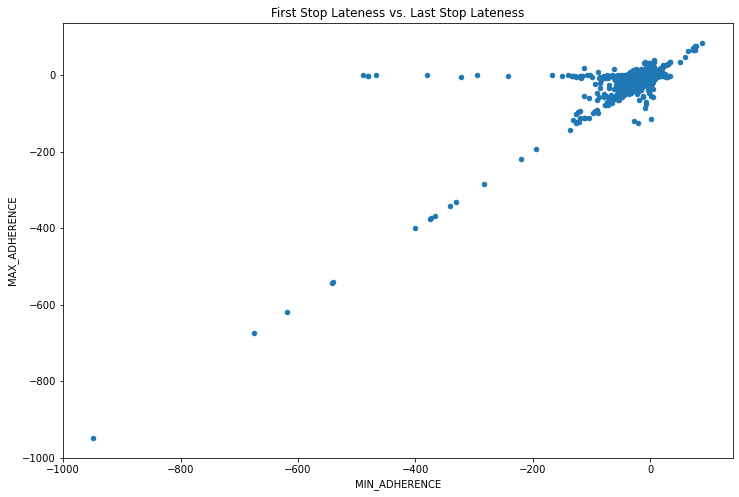

In [121]:
min_max_rank_adherence.plot(kind = 'scatter', x = 'MIN_ADHERENCE', y = 'MAX_ADHERENCE', figsize = (12,8))
plt.title('First Stop Lateness vs. Last Stop Lateness');